In [24]:
import torch
from scipy import integrate

def h_1(x):
    return x

def h_2(x):
    return x**2

# def F_1(x):
#     a = -1
#     b = 1
#     if x < a:
#         return 0
#     elif x >= b:
#         return 1
#     return (x-a)/(b-a)

def f_1(a, b, x):
    if x <= a:
        return 0
    elif x >= b:
        return 0
    return 1/(b-a)

def f_2(a, b, x):
    if x <= a:
        return 0
    elif x >= b:
        return 0
    return 1/(b-a)

# def integrand(x,y, beta_2):
#     return f_1((y-beta_2*h_2(x))/h_1(x))*f_2(beta_2)

# #print(integrate.nquad(integrand,[[0,1], [0,1], [0,1]]))

# def f_etax(x,y, beta):
#     fixed_integrand = lambda args: integrand(x, y, args)
#     result, error = integrate.nquad(fixed_integrand,[[-0.9,0.9]])
#     return result

# print(f_etax(0,1, [0,0.5]))


In [56]:
import mcint
import math
import random

def integrand_2(y, bounds, h, beta_2):
    a_1 = bounds[0][0]
    b_1 = bounds[0][1]
    a_2 = bounds[1][0]
    b_2 = bounds[1][1]
    h_1 = h[0]
    h_2 = h[1]
    return f_1(a_1, b_1, (y-beta_2*h_2)/h_1)*f_2(a_2, b_2, beta_2)

#print(integrate.nquad(integrand,[[0,1], [0,1], [0,1]]))
def sampler(bounds):
    a_2 = bounds[1][0]
    b_2 = bounds[1][1]
    while True:
        beta_2 = random.uniform(a_2, b_2)
        yield (beta_2)

#print(integrate.nquad(integrand,[[0,1], [0,1], [0,1]]))
domainsize = 1

def f_etax_2(y, beta, h):
    fixed_integrand = lambda args: integrand_2(y, beta, h, args)
    # result, error = integrate.nquad(fixed_integrand,[[-0.9,0.9]])
    # random.seed(2)
    n = 200
    result, error = mcint.integrate(fixed_integrand, sampler(beta), measure=domainsize, n=n)
    # result, error = integrate.nquad(fixed_integrand,[[beta[1][0], beta[1][1]]])
    
    # result = torch.trapezoid()
    # print(result)
    return torch.log(result)

def log_lik(y, beta, h_all):
    return sum([f_etax_2(y_i, beta, h_all[i]) for i, y_i in enumerate(y)])

# print(f_etax_2(0.4,0.55, [[-0.8,1.],[-1.,1.]]))


0 beta_1: [1.1 2.9] beta_2: [1.1 2.9] loss: tensor(-45.4590, grad_fn=<AddBackward0>)
1 beta_1: [1.2001358 2.7998643] beta_2: [1.2001358 2.7998643] loss: tensor(-40.7663, grad_fn=<AddBackward0>)
2 beta_1: [1.3004948 2.6995053] beta_2: [1.3004948 2.6995053] loss: tensor(-36.7586, grad_fn=<AddBackward0>)
3 beta_1: [1.4011525 2.5988476] beta_2: [1.4011525 2.5988476] loss: tensor(-32.5880, grad_fn=<AddBackward0>)
4 beta_1: [1.5021548 2.4978454] beta_2: [1.5021548 2.4978454] loss: tensor(-27.8214, grad_fn=<AddBackward0>)
5 beta_1: [1.6034801 2.3965201] beta_2: [1.6034801 2.3965201] loss: tensor(-25.5103, grad_fn=<AddBackward0>)
6 beta_1: [1.7054317 2.2945685] beta_2: [nan nan] loss: tensor(-inf, grad_fn=<AddBackward0>)
7 beta_1: [nan nan] beta_2: [nan nan] loss: tensor(nan, grad_fn=<AddBackward0>)
8 beta_1: [nan nan] beta_2: [nan nan] loss: tensor(nan, grad_fn=<AddBackward0>)
9 beta_1: [nan nan] beta_2: [nan nan] loss: tensor(nan, grad_fn=<AddBackward0>)


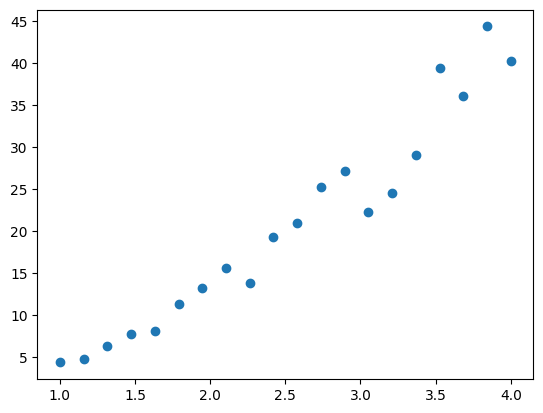

In [57]:
import time
import matplotlib.pyplot as plt
torch.manual_seed(1)

N = 20
x = torch.linspace(1,4, N)
a_1 = 1.7
b_1 = 2.6
a_2 = 1.2
b_2 = 2.8
y = (torch.FloatTensor(N).uniform_(a_1, b_1)*x) + (torch.FloatTensor(N).uniform_(a_1, b_1)*(x**2))

plt.scatter(x,y)

h_all = [h_1, h_2] 
h_all_data = [h(x) for h in h_all]
h_all = torch.transpose(torch.stack(h_all_data, 0), 0, 1)
beta_1 = torch.tensor([1.,3.], requires_grad=True)
beta_2 = torch.tensor([1.,3.], requires_grad=True)
beta = [beta_1, beta_2]

lr = 0.1

optimizer = torch.optim.Adam(beta,lr=lr, maximize=True)
old_loss = float('inf')
epochs = 10
cur_epoch = epochs
t1 = time.time()
t2 = float('inf')     # In case optimization doesnt terminate before max epochs are reached
print_frequency=1
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = log_lik(y, beta, h_all)
    loss.backward()
    optimizer.step()
    if epoch%print_frequency==0:
        print(epoch, "beta_1:", beta_1.detach().numpy(), "beta_2:", beta_2.detach().numpy(), "loss:", loss)
    if torch.abs(loss-old_loss) < 1e-15:
        t2 = time.time()
        cur_epoch = epoch
        break
    old_loss = loss

